In [26]:
! pip install pymorphy2
! pip install catboost
! pip install optuna

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.model_selection import train_test_split as tts
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
from catboost.utils import get_roc_curve, select_threshold
import optuna
from optuna.samplers import TPESampler
import catboost

In [28]:
df = pd.read_csv("wb_school_task_2.csv")

In [29]:
df

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.000000,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.700000,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.000000,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.000000,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.000000,6,4,5.000000,26,33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3118,764513678578182418,15635360211325277203,6836784353719029392,"Стекло не плохое,но есть один минус на техно с...",2,2,3.000000,19,1,4.263158,9,9,0
3119,6838893897482150395,13016265854619171030,12090430373311552618,"Всё пришло запаковано, ничего не сломано. Лучш...",8,8,4.375000,131,83,4.183206,18,18,0
3120,3080528623596565085,17787644417937804433,18003133089489520237,"Мне нравятся 👍🏻 я очень аллергичная, посоветов...",13,12,5.000000,145,2,4.944828,12,14,0
3121,13059704988549832630,997055248102065549,12214993272083833542,"Спасибо, целая пришла. Хорошо упаковано",3,3,5.000000,205,19,4.648780,103,155,0


In [30]:
df['word_len'] = df.text.apply(lambda x: len(x.split()))
df['sym_len'] = df.text.apply(len)

In [31]:
df["f1/f2"] = df["f1"]/df["f2"]
df["f1/f3"] = df["f1"]/df["f3"]
df["f1/f4"] = df["f1"]/df["f4"]
df["f1/f5"] = df["f1"]/df["f5"]
df["f1/f6"] = df["f1"]/df["f6"]
df["f1/f7"] = df["f1"]/df["f7"]
df["f1/f8"] = df["f1"]/df["f8"]

df["f2/f3"] = df["f2"]/df["f3"]
df["f2/f4"] = df["f2"]/df["f4"]
df["f2/f5"] = df["f2"]/df["f5"]
df["f2/f6"] = df["f2"]/df["f6"]
df["f2/f7"] = df["f2"]/df["f7"]
df["f2/f8"] = df["f2"]/df["f8"]

df["f3/f4"] = df["f3"]/df["f4"]
df["f3/f5"] = df["f3"]/df["f5"]
df["f3/f6"] = df["f3"]/df["f6"]
df["f3/f7"] = df["f3"]/df["f7"]
df["f3/f8"] = df["f3"]/df["f8"]

df["f4/f5"] = df["f4"]/df["f5"]
df["f4/f6"] = df["f4"]/df["f6"]
df["f4/f7"] = df["f4"]/df["f7"]
df["f4/f8"] = df["f4"]/df["f8"]

df["f5/f6"] = df["f5"]/df["f6"]
df["f5/f7"] = df["f5"]/df["f7"]
df["f5/f8"] = df["f5"]/df["f8"]

df["f6/f7"] = df["f6"]/df["f7"]
df["f6/f8"] = df["f6"]/df["f8"]

df["f7/f8"] = df["f7"]/df["f8"]

In [32]:
df["f1*f2"] = df["f1"]*df["f2"]
df["f1*f3"] = df["f1"]*df["f3"]
df["f1*f4"] = df["f1"]*df["f4"]
df["f1*f5"] = df["f1"]*df["f5"]
df["f1*f6"] = df["f1"]*df["f6"]
df["f1*f7"] = df["f1"]*df["f7"]
df["f1*f8"] = df["f1"]*df["f8"]

df["f2*f3"] = df["f2"]*df["f3"]
df["f2*f4"] = df["f2"]*df["f4"]
df["f2*f5"] = df["f2"]*df["f5"]
df["f2*f6"] = df["f2"]*df["f6"]
df["f2*f7"] = df["f2"]*df["f7"]
df["f2*f8"] = df["f2"]*df["f8"]

df["f3*f4"] = df["f3"]*df["f4"]
df["f3*f5"] = df["f3"]*df["f5"]
df["f3*f6"] = df["f3"]*df["f6"]
df["f3*f7"] = df["f3"]*df["f7"]
df["f3*f8"] = df["f3"]*df["f8"]

df["f4*f5"] = df["f4"]*df["f5"]
df["f4*f6"] = df["f4"]*df["f6"]
df["f4*f7"] = df["f4"]*df["f7"]
df["f4*f8"] = df["f4"]*df["f8"]

df["f5*f6"] = df["f5"]*df["f6"]
df["f5*f7"] = df["f5"]*df["f7"]
df["f5*f8"] = df["f5"]*df["f8"]

df["f6*f7"] = df["f6"]*df["f7"]
df["f6*f8"] = df["f6"]*df["f8"]

df["f7*f8"] = df["f7"]*df["f8"]

In [33]:
m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    return lemmas

In [34]:
lemmas = list(tqdm(map(clean_text, df['text']), total=len(df)))
df['lemmas'] = lemmas
df['lemmas'] = df.lemmas.apply(lambda x: " ".join(x))

100%|██████████| 3123/3123 [00:26<00:00, 120.06it/s]


In [21]:
X = df.drop(["label", "id1", "id2", "id3"], axis=1)
y = df["label"]

In [ ]:
#создание train/test выборок
X_train, X_test, y_train, y_test = tts(X, y, shuffle=True, stratify=y, train_size=0.7, random_state=123)

train_pool = Pool(
    X_train, y_train,
    text_features=["lemmas", "text"]
)

test_pool = Pool(
    X_test,
    text_features=["lemmas", "text"]
)

In [ ]:
#обучение модели на всех имеющихся признаках
model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.01,
                           loss_function='Logloss').fit(train_pool, verbose=100)

0:	learn: 0.6893707	total: 247ms	remaining: 4m 6s
100:	learn: 0.5240065	total: 20.8s	remaining: 3m 5s
200:	learn: 0.4812878	total: 40.5s	remaining: 2m 41s
300:	learn: 0.4612334	total: 1m 1s	remaining: 2m 23s
400:	learn: 0.4476326	total: 1m 22s	remaining: 2m 3s
500:	learn: 0.4363145	total: 1m 41s	remaining: 1m 41s
600:	learn: 0.4257358	total: 2m 2s	remaining: 1m 21s
700:	learn: 0.4153918	total: 2m 22s	remaining: 1m
800:	learn: 0.4026959	total: 2m 42s	remaining: 40.4s
900:	learn: 0.3882832	total: 3m 2s	remaining: 20.1s
999:	learn: 0.3744090	total: 3m 33s	remaining: 0us


In [ ]:
#выбор threshold
roc_curve_values = get_roc_curve(model, train_pool)
boundary = select_threshold(model, curve=roc_curve_values)
model.set_probability_threshold(boundary)

In [16]:
def get_metrics(y_true, y_pred) -> dict:

    metrics = {
        "recall_score": 0,
        "precision_score": 0,
        "f1_score" : 0
    }

    metrics["recall_score"] = recall_score(y_true, y_pred)
    metrics["precision_score"] = precision_score(y_true, y_pred)
    metrics["f1_score"] = f1_score(y_true, y_pred, average='micro')
    metrics["roc_auc_score"] = roc_auc_score(y_true, y_pred)

    return metrics

In [10]:
#предсказание и метрики
pred = model.predict(test_pool).flatten()
catboost_metrics = get_metrics(pred, y_test)
catboost_metrics

NameError: ignored

In [ ]:
def plot_feature_importance(importance,names,model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names, 'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,12))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

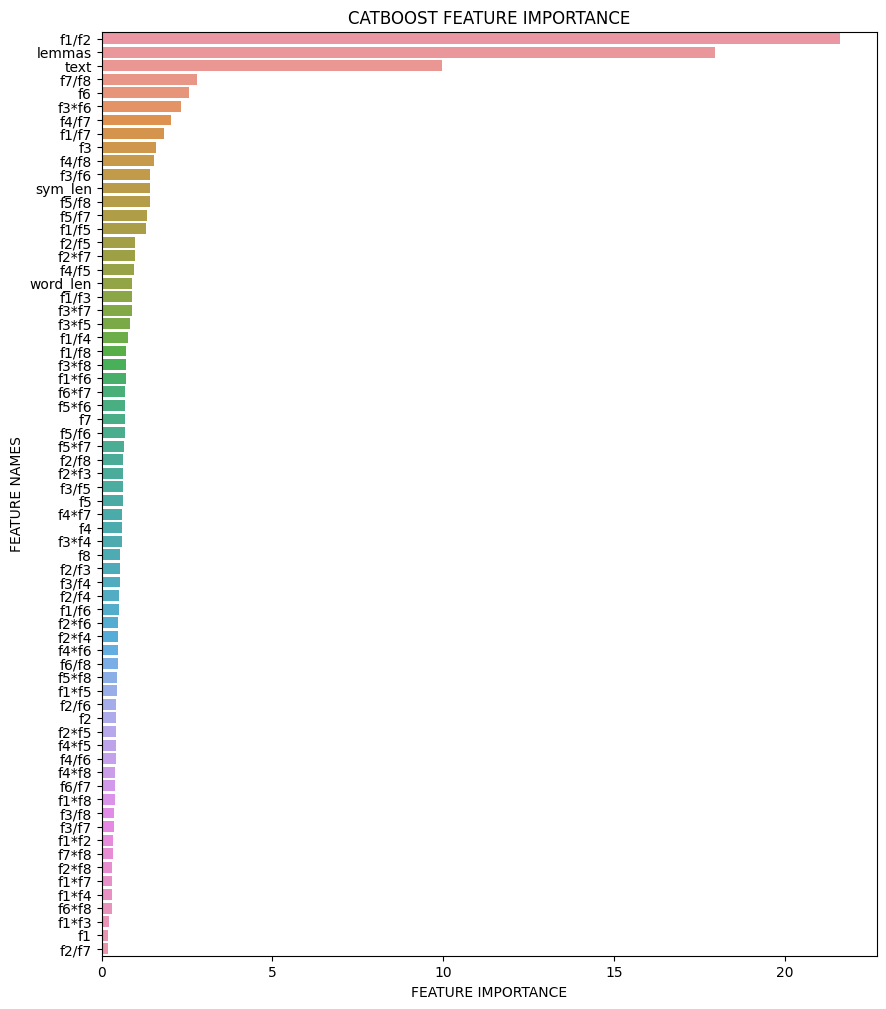

In [ ]:
#посмотрим на важность признаков
plot_feature_importance(model.get_feature_importance(), X_train.columns,'CATBOOST ')

In [24]:
#выберем топ-9 признаков и снова обучим модель
X = df[["f1/f2", "lemmas", "text", "f7/f8", "f6", "f3*f6", "f4/f7", "f1/f7", "f3"]]
y = df["label"]

#создание train/test выборок
X_train, X_test, y_train, y_test = tts(X, y, shuffle=True, stratify=y, train_size=0.7, random_state=123)

train_pool = Pool(
    X_train, y_train,
    text_features=["lemmas", "text"]
)

test_pool = Pool(
    X_test,
    text_features=["lemmas", "text"]
)

In [ ]:
#обучение модели
model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.01,
                           loss_function='Logloss').fit(train_pool, verbose=100)

0:	learn: 0.6897595	total: 309ms	remaining: 5m 8s
100:	learn: 0.5333920	total: 20.3s	remaining: 3m
200:	learn: 0.4950713	total: 40.3s	remaining: 2m 40s
300:	learn: 0.4768403	total: 59.8s	remaining: 2m 18s
400:	learn: 0.4651700	total: 1m 20s	remaining: 2m
500:	learn: 0.4548259	total: 1m 42s	remaining: 1m 41s
600:	learn: 0.4455106	total: 2m 3s	remaining: 1m 22s
700:	learn: 0.4356934	total: 2m 24s	remaining: 1m 1s
800:	learn: 0.4241617	total: 2m 48s	remaining: 41.8s
900:	learn: 0.4114339	total: 3m 9s	remaining: 20.9s
999:	learn: 0.3977156	total: 3m 31s	remaining: 0us


In [ ]:
#выбор threshold
roc_curve_values = get_roc_curve(model, train_pool)
boundary = select_threshold(model, curve=roc_curve_values)
model.set_probability_threshold(boundary)


#предсказание и метрики
pred = model.predict(test_pool).flatten()
catboost_metrics = get_metrics(pred, y_test)
catboost_metrics

{'recall_score': 0.47151898734177217,
 'precision_score': 0.6008064516129032,
 'f1_score': 0.7161152614727856,
 'roc_auc_score': 0.6560493487433497}

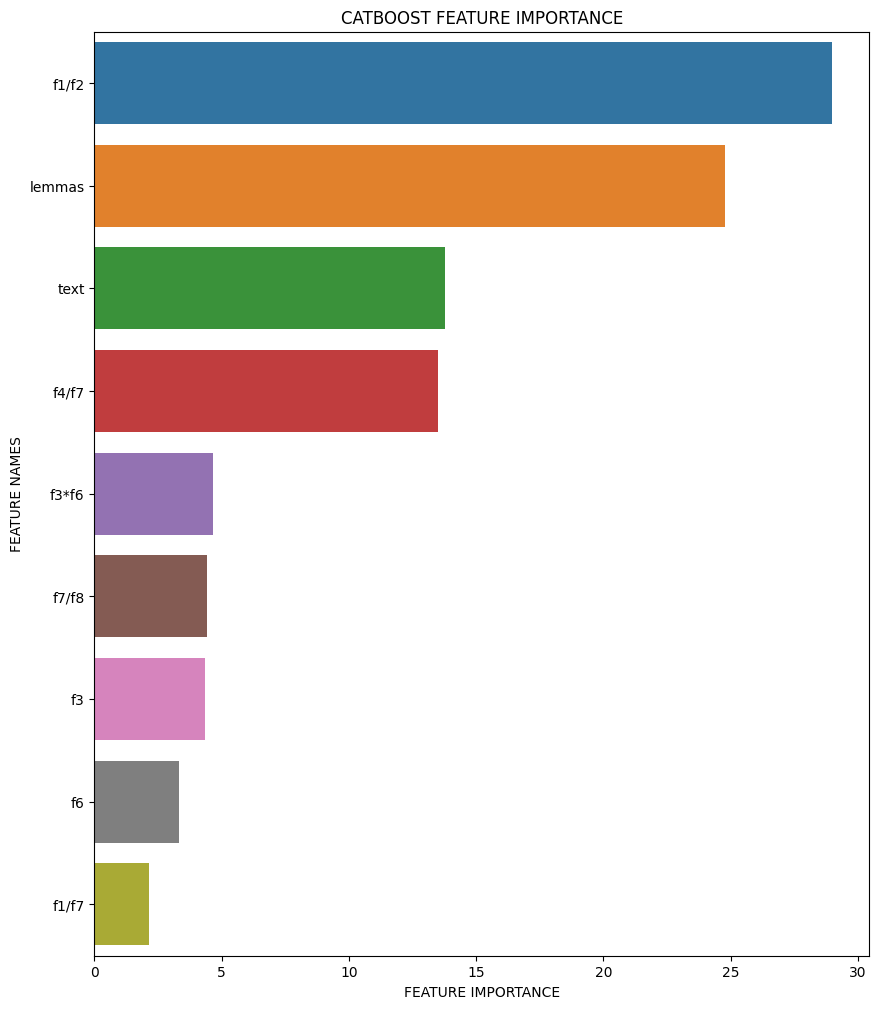

In [ ]:
#посмотрим на важность признаков
plot_feature_importance(model.get_feature_importance(), X_train.columns,'CATBOOST ')

In [25]:
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(train_pool)
    y_pred = model.predict(test_pool)
    return precision_score(y_test, y_pred)


In [26]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

In [27]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Number of finished trials:  100
Best trial:
  Value:  1.0
  Params: 
    iterations: 119
    learning_rate: 0.0011316127477798243
    depth: 7
    l2_leaf_reg: 52.92612734145876
    bootstrap_type: Bayesian
    random_strength: 9.907004084255085e-06
    bagging_temperature: 7.456016132398628
    od_type: Iter
    od_wait: 16


In [ ]:
Number of finished trials:  100
Best trial:
  Value:  1.0
  Params:
    iterations: 119
    learning_rate: 0.0011316127477798243
    depth: 7
    l2_leaf_reg: 52.92612734145876
    bootstrap_type: Bayesian
    random_strength: 9.907004084255085e-06
    bagging_temperature: 7.456016132398628
    od_type: Iter
    od_wait: 16

In [11]:
#выберем топ-9 признаков и снова обучим модель
X = df[["f1/f2", "lemmas", "text", "f7/f8", "f6", "f3*f6", "f4/f7", "f1/f7", "f3"]]
y = df["label"]

#создание train/test выборок
X_train, X_test, y_train, y_test = tts(X, y, shuffle=True, stratify=y, train_size=0.7, random_state=123)

train_pool = Pool(
    X_train, y_train,
    text_features=["lemmas", "text"]
)

test_pool = Pool(
    X_test,
    text_features=["lemmas", "text"]
)

In [22]:
#обучение модели на всех имеющихся признаках
model = CatBoostClassifier(
                            iterations=1000,
                            learning_rate=0.0011316127477798243,
                            depth=7,
                            l2_leaf_reg=52.92612734145876,
                            bootstrap_type="Bayesian",
                            random_strength=9.907004084255085e-06,
                            bagging_temperature=7.456016132398628,
                            od_type="Iter",
                            od_wait=16).fit(train_pool, verbose=100)

0:	learn: 0.6927201	total: 654ms	remaining: 10m 53s
100:	learn: 0.6598809	total: 59.5s	remaining: 8m 49s
200:	learn: 0.6325931	total: 1m 57s	remaining: 7m 49s
300:	learn: 0.6103255	total: 2m 57s	remaining: 6m 51s
400:	learn: 0.5916257	total: 3m 55s	remaining: 5m 51s
500:	learn: 0.5763519	total: 4m 53s	remaining: 4m 52s
600:	learn: 0.5636625	total: 5m 52s	remaining: 3m 53s
700:	learn: 0.5523820	total: 6m 49s	remaining: 2m 54s
800:	learn: 0.5430263	total: 7m 48s	remaining: 1m 56s
900:	learn: 0.5348835	total: 8m 46s	remaining: 57.8s
999:	learn: 0.5279175	total: 9m 52s	remaining: 0us


In [43]:
#выбор threshold
roc_curve_values = get_roc_curve(model, train_pool)
boundary = select_threshold(model, curve=roc_curve_values)
model.set_probability_threshold(boundary)

In [46]:
#предсказание и метрики
pred = model.predict(test_pool).flatten()
catboost_metrics = get_metrics(pred, y_test)
catboost_metrics

{'recall_score': 0.5914634146341463,
 'precision_score': 0.782258064516129,
 'f1_score': 0.7993596584845252,
 'roc_auc_score': 0.7513967319476149}

In [35]:
X = df[["f1/f2", "lemmas", "text", "f7/f8", "f6", "f3*f6", "f4/f7", "f1/f7", "f3"]]
y = df["label"]

pool = Pool(
    X, y,
    text_features=["lemmas", "text"]
)


model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.01,
                           loss_function='Logloss').fit(pool, verbose=100)

roc_curve_values = get_roc_curve(model, pool)
boundary = select_threshold(model, curve=roc_curve_values)
model.set_probability_threshold(boundary)

0:	learn: 0.6898097	total: 1.05s	remaining: 17m 28s
100:	learn: 0.5393680	total: 1m 1s	remaining: 9m 7s
200:	learn: 0.5029028	total: 1m 43s	remaining: 6m 50s
300:	learn: 0.4868916	total: 2m 27s	remaining: 5m 41s
400:	learn: 0.4765239	total: 3m 10s	remaining: 4m 43s
500:	learn: 0.4679319	total: 3m 52s	remaining: 3m 51s
600:	learn: 0.4606586	total: 4m 33s	remaining: 3m 1s
700:	learn: 0.4534755	total: 5m 15s	remaining: 2m 14s
800:	learn: 0.4441541	total: 5m 57s	remaining: 1m 28s
900:	learn: 0.4325810	total: 6m 41s	remaining: 44.1s
999:	learn: 0.4210219	total: 7m 22s	remaining: 0us


In [37]:
model.save_model("model")